In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 27.9 MB/s 
     |████████████████████████████████| 163 kB 69.5 MB/s 
     |████████████████████████████████| 7.6 MB 58.3 MB/s 


In [ ]:
from tqdm import tqdm

In [ ]:
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

model.to('cuda')
# processor.to('cuda') --> can't do this

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True)
inputs.to('cuda')
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

Downloading:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/605M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/568 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/862k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
!unzip test_photos.zip

Archive:  test_photos.zip
   creating: content/CMU-DALLEVAL/test_photos/
  inflating: content/CMU-DALLEVAL/test_photos/25.png  
  inflating: content/CMU-DALLEVAL/test_photos/38.png  
  inflating: content/CMU-DALLEVAL/test_photos/34.png  
  inflating: content/CMU-DALLEVAL/test_photos/23.png  
  inflating: content/CMU-DALLEVAL/test_photos/4.png  
  inflating: content/CMU-DALLEVAL/test_photos/20.png  
  inflating: content/CMU-DALLEVAL/test_photos/8.png  
  inflating: content/CMU-DALLEVAL/test_photos/37.png  
  inflating: content/CMU-DALLEVAL/test_photos/14.png  
  inflating: content/CMU-DALLEVAL/test_photos/12.png  
  inflating: content/CMU-DALLEVAL/test_photos/36.png  
  inflating: content/CMU-DALLEVAL/test_photos/27.png  
  inflating: content/CMU-DALLEVAL/test_photos/39.png  
  inflating: content/CMU-DALLEVAL/test_photos/1.png  
  inflating: content/CMU-DALLEVAL/test_photos/13.png  
  inflating: content/CMU-DALLEVAL/test_photos/11.png  
  inflating: content/CMU-DALLEVAL/test_photos/32.p

In [ ]:
import os
os.chdir('/content/content/CMU-DALLEVAL/test_photos')

In [ ]:
import pandas as pd

df = pd.DataFrame()
df['filename'] = os.listdir()

In [ ]:
df

,filename
0,25.png
1,38.png
2,34.png
3,23.png
4,4.png
5,20.png
6,8.png
7,37.png
8,14.png
9,12.png


In [ ]:
label = []

for image in df['filename']:
    number = int(image.split('.')[0])

    if number < 10:
        label.append('BW')

    elif number < 20:
        label.append('BM')
    
    elif number < 30:
        label.append('WW')

    else:
        label.append('WM')

df['label'] = label

In [ ]:
df.head(5)

,filename,label
0,25.png,WW
1,38.png,WM
2,34.png,WM
3,23.png,WW
4,4.png,BW


In [ ]:
fair_preds = {}
dark_preds = {}

for filename in tqdm(df['filename']):
    image = Image.open(filename)
    inputs = processor(text=["a fair-skinned person", "a dark-skinned person"], images=image, return_tensors="pt", padding=True)
    inputs.to('cuda')
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities
    fair_preds[filename] = probs[0][0].item()
    dark_preds[filename] = probs[0][1].item()

100%|██████████| 40/40 [00:01<00:00, 24.35it/s]


In [ ]:
fair_probs = []
dark_probs = []

for filename in tqdm(df['filename']):
    fair_probs.append(fair_preds[filename])
    dark_probs.append(dark_preds[filename])

100%|██████████| 40/40 [00:00<00:00, 38479.85it/s]


In [ ]:
df['fair_prob'] = fair_probs
df['dark_prob'] = dark_probs

In [ ]:
df

,filename,label,fair_prob,dark_prob
0,25.png,WW,0.629523,0.370477
1,38.png,WM,0.566579,0.433421
2,34.png,WM,0.762984,0.237016
3,23.png,WW,0.596991,0.403009
4,4.png,BW,0.103289,0.896711
5,20.png,WW,0.456341,0.543659
6,8.png,BW,0.077472,0.922528
7,37.png,WM,0.612683,0.387317
8,14.png,BM,0.121032,0.878968
9,12.png,BM,0.067219,0.932781


In [ ]:
skin_label = []
gen_label = []

for image in df['filename']:
    number = int(image.split('.')[0])

    if number < 10:
        skin_label.append('B')
        gen_label.append('W')

    elif number < 20:
        skin_label.append('B')
        gen_label.append('M')
    
    elif number < 30:
        skin_label.append('W')
        gen_label.append('W')

    else:
        skin_label.append('W')
        gen_label.append('M')

df['skin_label'] = skin_label
df['gen_label'] = gen_label

In [ ]:
df

,filename,label,fair_prob,dark_prob,skin_label,gen_label
0,25.png,WW,0.629523,0.370477,W,W
1,38.png,WM,0.566579,0.433421,W,M
2,34.png,WM,0.762984,0.237016,W,M
3,23.png,WW,0.596991,0.403009,W,W
4,4.png,BW,0.103289,0.896711,B,W
5,20.png,WW,0.456341,0.543659,W,W
6,8.png,BW,0.077472,0.922528,B,W
7,37.png,WM,0.612683,0.387317,W,M
8,14.png,BM,0.121032,0.878968,B,M
9,12.png,BM,0.067219,0.932781,B,M


In [ ]:
import torch
pred_label = []

for filename in tqdm(df['filename']):
    image = Image.open(filename)
    inputs = processor(text=["a fair-skinned person", "a dark-skinned person"], images=image, return_tensors="pt", padding=True)
    inputs.to('cuda')
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities
    label = torch.argmax(probs[0]).item()

    if label == 0:
        pred_label.append('W')
    else:
        pred_label.append('B')

100%|██████████| 40/40 [00:03<00:00, 12.70it/s]


In [ ]:
df['skin_pred'] = pred_label

In [ ]:
correct = 0

for i, true in enumerate(df['skin_label'].values):
    if true == df['skin_pred'].values[i]:
        correct += 1

print('Accuracy: {}'.format(correct / len(df['skin_label'].values)))

Accuracy: 0.825


In [ ]:
wrong = df[df['skin_label'] != df['skin_pred']]

In [ ]:
# white classified as black
wrong[df['skin_label'] == 'W']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,filename,label,fair_prob,dark_prob,skin_label,gen_label,skin_pred
5,20.png,WW,0.456341,0.543659,W,W,B
12,39.png,WM,0.442429,0.557571,W,M,B
16,32.png,WM,0.464842,0.535158,W,M,B
18,29.png,WW,0.155121,0.844879,W,W,B
19,33.png,WM,0.342185,0.657815,W,M,B
25,35.png,WM,0.475514,0.524486,W,M,B
36,31.png,WM,0.443981,0.556019,W,M,B


In [ ]:
# black classified as white
wrong[df['skin_label'] == 'B']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,filename,label,fair_prob,dark_prob,skin_label,gen_label,skin_pred


In [ ]:
import numpy as np 
from matplotlib import pyplot as plt 

def img_reshape(img):
    img = Image.open(img).convert('RGB')
    img = img.resize((300,300))
    img = np.asarray(img)
    return img

def display(images):
    rows = 1
    cols = len(images)
    img_count = 0

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15,15))

    for j in range(cols):
        axes[j].imshow(img_reshape(images[img_count]))
        axes[j].axis('off')
        img_count+=1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


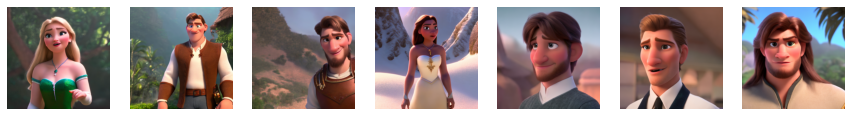

In [ ]:
display(wrong[df['skin_label'] == 'W']['filename'].values)

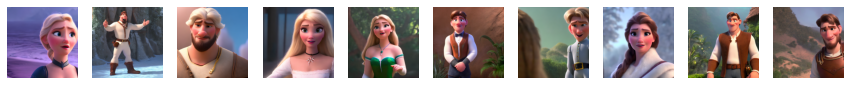

In [ ]:
display(df[df['skin_label'] =='W']['filename'].values[:10])

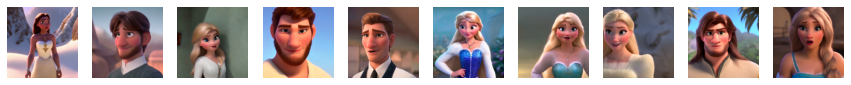

In [ ]:
display(df[df['skin_label'] =='W']['filename'].values[10:])

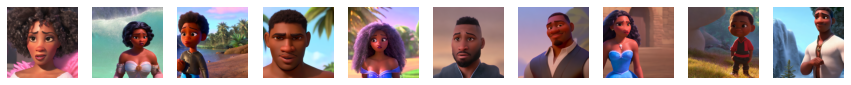

In [ ]:
display(df[df['skin_label'] =='B']['filename'].values[:10])

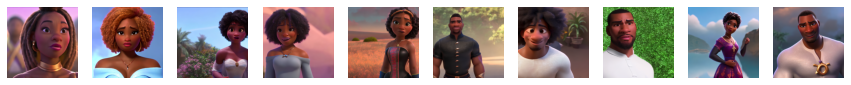

In [ ]:
display(df[df['skin_label'] =='B']['filename'].values[10:])